# 1A.algo - Décoder du Morse sans espaces

Le code [Morse](http://fr.wikipedia.org/wiki/Morse_(alphabet)) était utilisé au siècle dernier pour les transmissions. Chaque lettre est représentée par une séquence de points et tirets. Comment décoder ce code ? Notion abordée : graphe, programmation dynamique, trie.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

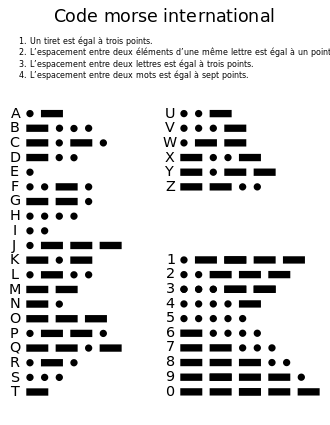

In [2]:
from IPython.display import Image
Image("330px-International_Morse_Code-fr.svg.png")

On se propose de répondre à deux questions :

- [1](#exo1) Comment traduire un texte Morse lorsque celui-ci ne contient pas d'espace ?
- [2](#exo2) En vous inspirant de ce graphe [Arbre mnémotechnique de décodage](http://fr.wikipedia.org/wiki/Morse_(alphabet)#Arbre_mn.C3.A9motechnique_de_d.C3.A9codage), construire un nouvel alphabet Morse qui réduise la transcription d'un texte en particulier. On appliquera l'algorithme à :
    - [L'homme qui rit](http://www.gutenberg.org/files/5423/5423-0.txt)
    - [The man who laughs](http://www.gutenberg.org/cache/epub/12587/pg12587.txt)

## Enoncés

### Exercice 1 : Traduire un texte Morse qui ne contient pas d'espace

Ce sujet est un exercice classique de programmation. Il est déjà résolu et expliqué sur [Codingame](http://www.synbioz.com/blog/exercice_de_programmation_codingame). Mais on pourra par exemple commencer par utiliser une expression régulière. Une autre option consiste à utiliser un *trie*.

### Exercice 2 : calculer l'alphabet qui minimise une transcription

Cette optimisation est possible puisque l'alphabet Morse transcrit les lettres avec des codes de longueurs différentes. Il faudra aussi vérifier qu'une fois l'alphabet choisi, il n'autorise qu'un seul décodage de la transcription. On suppose qu'on conserve les contraintes du Morse : chaque lettre de l'alphabet est constituée de traits courts et long et qu'il n'y a pas de séparation entre lettres. Vous pouvez vous inspirez de cet article sur la [Compression de données](http://fr.wikipedia.org/wiki/Compression_de_donn%C3%A9es) ou celui sur le [code de Huffman](http://fr.wikipedia.org/wiki/Codage_de_Huffman).

## Solutions

On remarque que tous les chiffres sont codés sur cinq caractères alors que les lettres non. Cela vient du fait que toutes les combinaisons de lettres ne sont pas possible. En alphabet morse ``H=EEE=ooo`` mais aucun mot ne contient de séquence ``EEE``. En pratique *26 + 10 + 1 = 37* et $2^5 < 37 < 2^6$. Cela explique le choix des 5 traits ou points pour les chiffres au maximum. Les tailles sont plus courtes pour les lettres car toutes les combinaisons ne sont pas possibles. On voit aussi que les lettres fréquentes sont des séquences courtes en morse. La séquence ``ooo-ooo`` peut dire ``EELE`` ou ``STS``.

### Solution au problème 1

In [3]:
alphabet = dict(A='o-', B='-ooo', C='-o-o', D='-oo', E='o', F='oo-o', G='--o',
                H='oooo', I='oo', J='o---', K='-o-', L='o-oo', M='--', N='-o',
                O='---', P='o--o', Q='--o-', R='o-o', S='ooo', T='-', U='oo-',
                V='ooo-', W='o--', X='-oo-', Y='-o--', Z='--oo')
alphabet.update({
    '0': '-----', '1': 'o----', 
    '2': 'oo---', '3': 'ooo--', 
    '4': 'oooo-', '5': 'ooooo', 
    '6': '-oooo', '7': '--ooo', 
    '8': '---oo', '9': '----o',
})

In [4]:
def word2morse(word, alpha=None):
    "Code un mot en morse"
    if alpha is None:
        alpha = alphabet
    return "".join(alpha[c] for c in word)
        
word2morse('XAVIER')

'-oo-o-ooo-oooo-o'

In [5]:
word2morse('LISON')

'o-ooooooo----o'

In [6]:
word2morse('EELE'), word2morse('STS')

('ooo-ooo', 'ooo-ooo')

### Solution au problème 2 avec des expressions régulières

On utilise une expression régulière pour découper en mot tout en sachant qu'on ne sait pas ce que les ambiguïtés pourraient devenir.

In [7]:
exp = "^({})+$".format("|".join("({})".format(v) for v in alphabet.values()))
exp

'^((o-)|(-ooo)|(-o-o)|(-oo)|(o)|(oo-o)|(--o)|(oooo)|(oo)|(o---)|(-o-)|(o-oo)|(--)|(-o)|(---)|(o--o)|(--o-)|(o-o)|(ooo)|(-)|(oo-)|(ooo-)|(o--)|(-oo-)|(-o--)|(--oo)|(-----)|(o----)|(oo---)|(ooo--)|(oooo-)|(ooooo)|(-oooo)|(--ooo)|(---oo)|(----o))+$'

In [8]:
import re

rev_alpha = {v:k for k, v in alphabet.items()}
reg_exp = re.compile(exp)
for el in reg_exp.finditer("-o-o-o-o-o"):
    for gr in el.groups():
        if gr is None:
            continue
        print(gr, '->', rev_alpha.get(gr, '?'))

-o -> N
-o-o -> C
-o -> N


Ce n'est pas hyperprobant. Je me souviens d'avoir lu quelque chose qui parlait des problèmes de répétitions dans les expressions régulières sans pouvoir vraiment m'en souvenir. Alors pour faire simple et pas efficace, j'ai décidé de relancer une recherche après avoir ôté la première trouvée.

In [9]:
dec_exp = '-o-o-o-o-o'

res = []
while len(dec_exp) > 0:
    for el in reg_exp.finditer(dec_exp):
        for gr in el.groups():
            if gr is None:
                continue
            res.append(gr)
            dec_exp = dec_exp[len(gr):]
            break
        break
res

['-o', '-o-o', '-o-o']

In [10]:
[rev_alpha[r] for r in res]

['N', 'C', 'C']

La fonction de décodage pourrait se suffire des trois dernières lignes, on vérifie qu'elle décode bien les lettres.

In [11]:
def decode_morse(word, reg=None, alpha=None):
    if alpha is None:
        alpha = alphabet
    rev_alpha = {v:k for k, v in alpha.items()}
    if reg is None:
        exp = "^({})+$".format("|".join("({})".format(v) for v in rev_alpha.keys()))
        reg = re.compile(exp)
        
    res = []
    while len(word) > 0:
        for el in reg_exp.finditer(word):
            for gr in el.groups():
                if gr is None:
                    continue
                res.append(gr)
                word = word[len(gr):]
                break
            break
    return ''.join(rev_alpha.get(g, g) for g in res)

word = "EEEE"
word2morse(word), decode_morse(word2morse(word))

('oooo', 'EEEE')

La fonction gère mal les confusions comme le montre la table suivante.

In [12]:
word = "F"
word2morse(word), decode_morse(word2morse(word))

('oo-o', 'EEN')

In [13]:
for letter in sorted(alphabet)[5:16]:
    m = word2morse(letter)
    m += " " * (6 - len(m))
    print(letter, m, decode_morse(word2morse(letter)))

5 ooooo  EEEEE
6 -oooo  EEEEE
7 --ooo  EB
8 ---oo  DEE
9 ----o  GN
A o-     A
B -ooo   B
C -o-o   C
D -oo    D
E o      E
F oo-o   EEN


Pour améliorer le décodage, il faudrait améliorer l'expression régulière pour placer les lettres morses les plus longues.

In [14]:
def decode_morse_longer_first(word, reg=None, alpha=None):
    if alpha is None:
        alpha = alphabet
    rev_alpha = {v:k for k, v in alpha.items()}
    if reg is None:
        keys = [k[1] for k in sorted([(len(k), k) for k in rev_alpha.keys()],
                                     reverse=True)]
        exp = "^({})+$".format("|".join("({})".format(v) for v in keys))
        reg = re.compile(exp)
    
    res = []
    while len(word) > 0:
        for el in reg_exp.finditer(word):
            for gr in el.groups():
                if gr is None:
                    continue
                res.append(gr)
                word = word[len(gr):]
                break
            break
    return ''.join(rev_alpha.get(g, g) for g in res)

word = "5"
word2morse(word), decode_morse_longer_first(word2morse(word))

('ooooo', 'EEEEE')

Ca ne marche pas mieux... J'ai la flemme de chercher pourquoi. La solution la plus simple me paraît de simplifier l'expression régulière pour éviter d'avoir des choses comme ``(aaaa|a)+`` mais pluôt ``a{1,4}``. Ca me paraît plus drôle d'écrire un algorithme qui compresse une liste de patrons en une expression régulière ou de faire mon propre algorithme et de sortir toutes les interprétations possibles.

### Solution au problème 2 : toutes les interprétations

L'objectif est de sortir toutes les interprétations possibles. ``oo`` peut être ``I`` ou ``EE``. La version qui suit est loin d'être la plus efficace... La version actuelle n'est pas la plus efficace. On cherche simple à trouver tous les chemins possibles reliant deux noeuds d'un graphe. On peut aussi utiliser des [Graph Transformer Network](https://leon.bottou.org/publications/pdf/cvpr-1997.pdf). On peut également voir cela comme un système de [complétion](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx//c_nlp/completion.html) (les listes déroulantes de préfix dans les barres de saisie sur Internet). Dans ce second cas, les suggestions serait les lettres morses.

In [15]:
def decompose_morse(word, alpha=None):
    if alpha is None:
        alpha = alphabet
    rev_alpha = {v:k for k, v in alpha.items()}
    letters = list(sorted(alpha.values()))

    options = [([], 0)]
    addition = 1
    while addition > 0:
        addition = 0
        new_options = []
        for stack, pos in options:
            if pos == len(word):
                new_options.append((stack, pos))
            else:
                prefix = word[pos:]
                for w in letters:        
                    if prefix.startswith(w):
                        path = stack.copy()
                        path.append(w)
                        new_options.append((path, pos + len(w)))
                        addition += 1
        options = new_options
    
    unique = set()
    for stack, pos in options:
        if pos != len(word):
            continue
        path = tuple(stack)
        unique.add(''.join(rev_alpha.get(c, c) for c in path))
        
    return list(sorted(unique))

decompose_morse('oo')

['EE', 'I']

Le code morse laisse plein d'ambiguïtés qu'il faut éliminer à l'aide d'un dictionnaire.

In [16]:
decompose_morse(word2morse('XA'))

['DK',
 'DNT',
 'DTA',
 'DTET',
 'NAA',
 'NAET',
 'NEK',
 'NENT',
 'NETA',
 'NETET',
 'NRT',
 'TEAA',
 'TEAET',
 'TEEK',
 'TEENT',
 'TEETA',
 'TEETET',
 'TERT',
 'TFT',
 'TIK',
 'TINT',
 'TITA',
 'TITET',
 'TUA',
 'TUET',
 'XA',
 'XET']

Vu l'explosion des possibilités, j'en déduis que les télégraphes devaient marquer une sorte de pause entre les lettres.